### Determining Hit Percentages for the Onset of the Feb 2021 CAO 
(Determined to be Feb 7th)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from metpy.units import units
from metpy import calc as mpcalc
import math
import netCDF4
from netCDF4 import Dataset
from datetime import datetime, date, timedelta
from itertools import chain

Importing in era-i, era-5, and S2S model data that's been averaged over a lat-lon. All data is at 00Z and 1000hPa

In [2]:
#Reading in rd_t Datasets made in ensemble_mean script (odd=hightop, even=lowtop)
ct_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/ct_llmn_t.nc")
stdvt_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/stdvt_llmn_t.nc")
rt1_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/realt_jan.nc")
rt2_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/realt_feb.nc")
t_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/ECMWF_llmn_t.nc")
t2_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/ECCC_llmn_t.nc")
t3_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/UKMO_llmn_t.nc")
t4_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/CMA_llmn_t.nc")
t5_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/JMA_llmn_t.nc")
t6_llmn_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/box_proj/box1_data/llmn_t/CNR_llmn_t.nc")

In [3]:
#Joining together the era-5 data in order to have January and February data together in one dataset
rt_llmn_ds = xr.concat([rt1_llmn_ds,rt2_llmn_ds], dim='time')

In [4]:
#Creating variables for the step and date of forecast
step = t_llmn_ds.step["step.days"] #<-- days forecasted out (47)
fd = t_llmn_ds.date["date.dayofyear"] #<--day of forecast(8)
step2 = t2_llmn_ds.step["step.days"] #<-- days forecasted out (32)
fd2 = t2_llmn_ds.date["date.dayofyear"] #<--day of forecast(4)
step3 = t3_llmn_ds.step["step.days"] 
fd3 = t3_llmn_ds.date["date.dayofyear"]
step4 = t4_llmn_ds.step["step.days"] 
fd4 = t4_llmn_ds.date["date.dayofyear"]
step5 = t5_llmn_ds.step["step.days"] 
fd5 = t5_llmn_ds.date["date.dayofyear"]
step6 = t6_llmn_ds.step["step.days"]
fd6 = t6_llmn_ds.date["date.dayofyear"]

#Creating time and number variables
time = ct_llmn_ds['time']
rt_time = rt_llmn_ds.time['time.dayofyear']
n1 = t_llmn_ds['number'].to_numpy()
n2 = t2_llmn_ds['number'].to_numpy()
n3 = t3_llmn_ds['number'].to_numpy()
n4 = t4_llmn_ds['number'].to_numpy()
n5 = t5_llmn_ds['number'].to_numpy()
n6 = t6_llmn_ds['number'].to_numpy()

In [5]:
#Creating data array of forecast day and step
doy1 = fd + step
doy2 = fd2 + step2
doy3 = fd3 + step3
doy4 = fd4 + step4
doy5 = fd5 + step5
doy6 = fd6 + step6

Following cell is making the climo (era-i) data's coordinates match the model data

In [6]:
#Assigning number to climo lat/lon means
ct1_match = ct_llmn_ds.assign_coords(number=('number', n1))
ct2_match = ct_llmn_ds.assign_coords(number=('number', n2))
ct3_match = ct_llmn_ds.assign_coords(number=('number', n3))
ct4_match = ct_llmn_ds.assign_coords(number=('number', n4))
ct5_match = ct_llmn_ds.assign_coords(number=('number', n5))
ct6_match = ct_llmn_ds.assign_coords(number=('number', n6))

#Giving climo data forecast days and steps
ct1_match = ct1_match.sel(time=doy1)
ct2_match = ct2_match.sel(time=doy2)
ct3_match = ct3_match.sel(time=doy3)
ct4_match = ct4_match.sel(time=doy4)
ct5_match = ct5_match.sel(time=doy5)
ct6_match = ct6_match.sel(time=doy6)
ct_rt_match = ct_llmn_ds.sel(time=rt_time)
stdvt_match = stdvt_llmn_ds.sel(time=rt_time)

Calculating the temperature anomalies for the model data and the era-5 data

In [7]:
#Calculating Mean Area Temp Anoms
anom_t = t_llmn_ds - ct1_match
anom_t2 = t2_llmn_ds - ct2_match
anom_t3 = t3_llmn_ds - ct3_match
anom_t4 = t4_llmn_ds - ct4_match
anom_t5 = t5_llmn_ds - ct5_match
anom_t6 = t6_llmn_ds - ct6_match
anom_rt = rt_llmn_ds.t.values - ct_rt_match.t.values

In [8]:
#Era-5 data is weird so, I'm making the actual anomalies back into xarray
anom_rt_ds = xr.DataArray(data=anom_rt, dims=["time"], coords=dict(time=rt_time),
                        attrs=dict(description="Temperature Anomaly", units="Kelvin"),)

Below are a couple of plots where I'm just playing with the data.

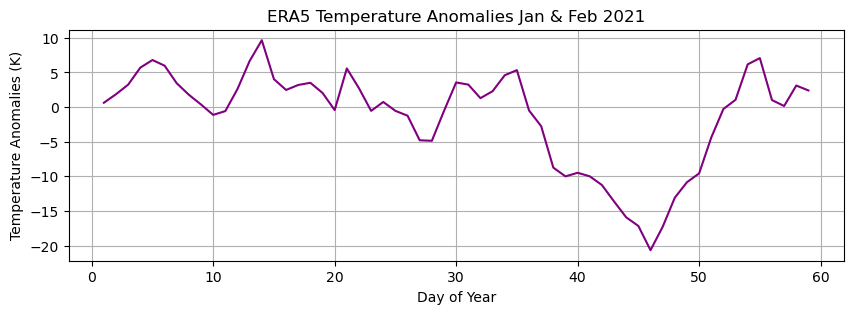

In [9]:
#Plotting the actual temperature anomalies
anom_rt_ds.plot(color='purple')
plt.grid(True)
plt.title('ERA5 Temperature Anomalies Jan & Feb 2021')
plt.xlabel('Day of Year')
plt.ylabel('Temperature Anomalies (K)')
fig = mlp.pyplot.gcf()
fig.set_size_inches(10, 3)

Determining the onset and length of the CAO which was determined to be Feb 7th-19th

In [10]:
time_of_CAO = anom_rt_ds < -.75* stdvt_match
time_of_CAO #<--From this, it's determined that the CAO begins on Feb 7th and lasts until Feb 19th

<xarray.Dataset>
Dimensions:  (time: 59)
Coordinates:
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 55.0 56.0 57.0 58.0 59.0
    hour     float64 ...
    lev      int32 ...
    level    int32 1000
Data variables:
    t        (time) bool False False False False ... False False False False

Creating date variable in order to select the day I want (February 7th)

In [11]:
dayiwant=anom_t['date'][0] + anom_t['step'][34]
dayiwant_jma=anom_t5['date'][0] + anom_t5['step'][32] 

In [12]:
#This is looping over each of the models in order to determine the date and step needed in 
# order to get the wanted date (FEB 7th)
stp1 = []
for ii in anom_t['date']:
    for jj in anom_t['step']:
        if ii + jj == dayiwant:
            ii1 = ii.date.values
            jj1 = jj.step.dt.days.values.tolist()
            stp1.append(jj1)
#            print(f'ECMWF:{ii1}, {jj1}')
stp2 = []
for ii in anom_t2['date']:
    for jj in anom_t2['step']:
        if ii + jj == dayiwant:
            ii2 = ii.date.values
            jj2 = jj.step.dt.days.values.tolist()
            stp2.append(jj2)
#            print(f'ECCC:{ii2}, {jj2}')
stp3 = []            
for ii in anom_t3['date']:
    for jj in anom_t3['step']:
        if ii + jj == dayiwant:
            ii3 = ii.date.values
            jj3 = jj.step.dt.days.values.tolist()
            stp3.append(jj3)
#            print(f'UKMO:{ii3}, {jj3}')
stp4 = []                        
for ii in anom_t4['date']:
    for jj in anom_t4['step']:
        if ii + jj == dayiwant:
            ii4 = ii.date.values
            jj4 = jj.step.dt.days.values.tolist()
            stp4.append(jj4)
#            print(f'CMA:{ii4}, {jj4}')
stp5 = []                        
for ii in anom_t5['date']:
    for jj in anom_t5['step']:
        if ii + jj == dayiwant_jma:
            ii5 = ii.date.values
            jj5 = jj.step.dt.days.values.tolist()
            stp5.append(jj5)
#            print(f'JMA:{ii5}, {jj5}')
stp6 = []            
for ii in anom_t6['date']:
    for jj in anom_t6['step']:
        if ii + jj == dayiwant:
            ii6 = ii.date.values
            jj6 = jj.step.dt.days.values.tolist()
            stp6.append(jj6)
#            print(f'CNR:{ii6}, {jj6}')

In [13]:
cao_length = slice("2021-02-07T00:00:00.000000000", "2021-02-19T00:00:00.000000000")

Determining the ERA-I Standard Deviation of Temp for Feb 7th

In [14]:
stdv_cao_len = stdvt_match.t.isel(time = slice(37,50))
stdv_feb7 = stdv_cao_len[0]

Below we are determining the number of hits for the initialization of the event. This is the number of ensemble runs that were able to successfully predict the CAO on Feb7th.

In [15]:
test = xr.where(anom_t<= -0.75 * stdv_feb7, anom_t, 0)
test

<xarray.Dataset>
Dimensions:  (date: 8, step: 47, number: 50)
Coordinates:
    level    int32 1000
  * number   (number) int32 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50
  * step     (step) timedelta64[ns] 0 days 1 days 2 days ... 45 days 46 days
  * date     (date) datetime64[ns] 2021-01-04 2021-01-07 ... 2021-01-28
    hour     float64 0.0
    lev      int32 1000
    time     (date, step) float64 4.0 5.0 6.0 7.0 8.0 ... 71.0 72.0 73.0 74.0
Data variables:
    t        (date, step, number) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [16]:
#Making a definition in order to determine the ensemble number that successfully predicted the CAO
## https://stackoverflow.com/questions/5419204/index-of-duplicates-items-in-a-python-list
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs


In [17]:
ecmwf_hits = []
ecmwf_ensnum = []
for m in range(0,8,1): #<-- This loop determines the number of ensemblessuccessful CAO predictions 
    at_sel1 = anom_t.sel(date = anom_t.date == anom_t.date[m],step=anom_t.step.dt.days == stp1[m])
    cao_t1 = at_sel1 <= -0.75 * stdv_feb7
    ct1 = cao_t1.where(cao_t1.t == True)
    ctf1 = ct1.sum().t.values.tolist()
    ecmwf_hits.append(ctf1)
    
    for k in range(0,50,1): #<--This loop determines which ensemble runs successfully predicted the CAO
        succ_ens_list = cao_t1.t.values.tolist()
        succ_ens_list = list(chain.from_iterable(list(chain.from_iterable(succ_ens_list))))
        succ_ensnum = list_duplicates_of(succ_ens_list, True)
    ecmwf_ensnum.append(succ_ensnum)
print(f'Successful Ensemble Runs:{ecmwf_ensnum}') #<-- Note you must add 1 to the value for the ensemble # due to the way that they are determined
print(f'Number of Hits:{ecmwf_hits}')

Successful Ensemble Runs:[[6, 11, 12, 16, 20, 38, 39, 44, 45], [5, 6, 9, 12, 15, 20, 24, 27, 29, 32, 36, 40, 42, 45], [3, 4, 22, 26], [9, 15, 24, 30, 37, 42, 46], [5, 15, 25, 27, 31, 32, 38, 41, 43, 48], [9, 22, 43, 45], [3, 16, 18, 26, 30, 33, 36, 40, 42, 48], [0, 1, 3, 5, 9, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 25, 28, 31, 32, 34, 35, 37, 39, 40, 42, 43, 46, 47]]
Number of Hits:[9.0, 14.0, 4.0, 7.0, 10.0, 4.0, 10.0, 28.0]


In [18]:
eccc_hits = []
eccc_ensnum = []
for m in range(0,4,1): #<-- This loop determines the number of ensemblessuccessful CAO predictions 
    at_sel1 = anom_t2.sel(date = anom_t2.date == anom_t2.date[m],step=anom_t2.step.dt.days == stp2[m])
    cao_t1 = at_sel1 <= -0.75 * stdv_feb7
    ct1 = cao_t1.where(cao_t1.t == True)
    ctf1 = ct1.sum().t.values.tolist()
    eccc_hits.append(ctf1)
    
    for k in range(0,20,1): #<--This loop determines which ensemble runs successfully predicted the CAO
        succ_ens_list = cao_t1.t.values.tolist()
        succ_ens_list = list(chain.from_iterable(list(chain.from_iterable(succ_ens_list))))
        succ_ensnum = list_duplicates_of(succ_ens_list, True)
    eccc_ensnum.append(succ_ensnum)
print(f'Successful Ensemble Runs:{eccc_ensnum}') 
print(f'Number of Hits:{eccc_hits}')

Successful Ensemble Runs:[[2, 16, 17], [4, 6, 7, 15], [9, 14, 16, 17], [0, 1, 2, 3, 5, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19]]
Number of Hits:[3.0, 4.0, 4.0, 15.0]


In [19]:
ukmo_hits = []
ukmo_ensnum = []
for m in range(0,31,1): #<-- This loop determines the number of ensemblessuccessful CAO predictions 
    at_sel1 = anom_t3.sel(date = anom_t3.date == anom_t3.date[m],step=anom_t3.step.dt.days == stp3[m])
    cao_t1 = at_sel1 <= -0.75 * stdv_feb7
    ct1 = cao_t1.where(cao_t1.t == True)
    ctf1 = ct1.sum().t.values.tolist()
    ukmo_hits.append(ctf1)
    
    for k in range(0,3,1): #<--This loop determines which ensemble runs successfully predicted the CAO
        succ_ens_list = cao_t1.t.values.tolist()
        succ_ens_list = list(chain.from_iterable(list(chain.from_iterable(succ_ens_list))))
        succ_ensnum = list_duplicates_of(succ_ens_list, True)
    ukmo_ensnum.append(succ_ensnum)
print(f'Successful Ensemble Runs:{ukmo_ensnum}') 
print(f'Number of Hits:{ukmo_hits}')

Successful Ensemble Runs:[[], [0], [0], [2], [], [], [], [], [], [0], [1], [1], [], [], [], [1, 2], [0], [2], [], [], [], [], [1], [], [], [], [0, 2], [], [], [2], []]
Number of Hits:[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0]


In [20]:
cma_hits = []
cma_ensnum = []
for m in range(0,8,1): #<-- This loop determines the number of ensemblessuccessful CAO predictions 
    at_sel1 = anom_t4.sel(date = anom_t4.date == anom_t4.date[m],step=anom_t4.step.dt.days == stp4[m])
    cao_t1 = at_sel1 <= -0.75 * stdv_feb7
    ct1 = cao_t1.where(cao_t1.t == True)
    ctf1 = ct1.sum().t.values.tolist()
    cma_hits.append(ctf1)
    
    for k in range(0,3,1): #<--This loop determines which ensemble runs successfully predicted the CAO
        succ_ens_list = cao_t1.t.values.tolist()
        succ_ens_list = list(chain.from_iterable(list(chain.from_iterable(succ_ens_list))))
        succ_ensnum = list_duplicates_of(succ_ens_list, True)
    cma_ensnum.append(succ_ensnum)
print(f'Successful Ensemble Runs:{cma_ensnum}') 
print(f'Number of Hits:{cma_hits}')

Successful Ensemble Runs:[[], [], [], [2], [], [], [], []]
Number of Hits:[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [21]:
jma_hits = []
jma_ensnum = []
for m in range(0,4,1): #<-- This loop determines the number of ensemblessuccessful CAO predictions 
    at_sel1 = anom_t5.sel(date = anom_t5.date == anom_t5.date[m],step=anom_t5.step.dt.days == stp5[m])
    cao_t1 = at_sel1 <= -0.75 * stdv_feb7
    ct1 = cao_t1.where(cao_t1.t == True)
    ctf1 = ct1.sum().t.values.tolist()
    jma_hits.append(ctf1)
    
    for k in range(0,49,1): #<--This loop determines which ensemble runs successfully predicted the CAO
        succ_ens_list = cao_t1.t.values.tolist()
        succ_ens_list = list(chain.from_iterable(list(chain.from_iterable(succ_ens_list))))
        succ_ensnum = list_duplicates_of(succ_ens_list, True)
    jma_ensnum.append(succ_ensnum)
print(f'Successful Ensemble Runs:{jma_ensnum}') 
print(f'Number of Hits:{jma_hits}')

Successful Ensemble Runs:[[0, 11, 15, 18, 23, 30, 34, 36, 37, 43, 48], [1, 6, 8, 10, 11, 13, 20, 28, 42, 48], [3, 15, 16], [0, 2, 3, 6, 7, 9, 12, 13, 17, 18, 19, 20, 23, 24, 25, 26, 28, 29, 31, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 48]]
Number of Hits:[11.0, 10.0, 3.0, 30.0]


In [22]:
cnr_hits = []
cnr_ensnum = []
for m in range(0,4,1): #<-- This loop determines the number of ensemblessuccessful CAO predictions 
    at_sel1 = anom_t6.sel(date = anom_t6.date == anom_t6.date[m],step=anom_t6.step.dt.days == stp6[m])
    cao_t1 = at_sel1 <= -0.75 * stdv_feb7
    ct1 = cao_t1.where(cao_t1.t == True)
    ctf1 = ct1.sum().t.values.tolist()
    cnr_hits.append(ctf1)
    
    for k in range(0,40,1): #<--This loop determines which ensemble runs successfully predicted the CAO
        succ_ens_list = cao_t1.t.values.tolist()
        succ_ens_list = list(chain.from_iterable(list(chain.from_iterable(succ_ens_list))))
        succ_ensnum = list_duplicates_of(succ_ens_list, True)
    cnr_ensnum.append(succ_ensnum)
print(f'Successful Ensemble Runs:{cnr_ensnum}') 
print(f'Number of Hits:{cnr_hits}')

Successful Ensemble Runs:[[1, 16, 31], [10, 13, 35, 37], [3, 4, 5, 8, 10, 14], [0, 2, 4, 5, 6, 7, 8, 11, 12, 15, 17, 19, 20, 23, 24, 26, 28, 32, 36, 37, 38]]
Number of Hits:[3.0, 4.0, 6.0, 21.0]


In [23]:
#Calculating Percent averages for each model
ecmwf_per = np.sum(ecmwf_hits)/(8*50)*100
eccc_per = np.sum(eccc_hits)/(4*20)*100
ukmo_per = np.sum(ukmo_hits)/(31*3)*100
cma_per = np.sum(cma_hits)/(8*3)*100
jma_per = np.sum(jma_hits)/(49*4)*100
cnr_per = np.sum(cnr_hits)/(40*4)*100

#Calculating Averages for HT vs LT models
ht_per = (ecmwf_per + ukmo_per + jma_per)/3
lt_per = (eccc_per + cma_per + cnr_per)/3

print(f'ECMWF:{ecmwf_per}')
print(f'ECCC:{eccc_per}')
print(f'UKMO:{ukmo_per}')
print(f'CMA:{cma_per}')
print(f'JMA:{jma_per}')
print(f'CNR:{cnr_per}')
print(f'HT:{ht_per}')
print(f'LT:{lt_per}')

ECMWF:21.5
ECCC:32.5
UKMO:15.053763440860216
CMA:4.166666666666666
JMA:27.55102040816326
CNR:21.25
HT:21.368261283007826
LT:19.305555555555554


In [24]:
#Creating Slices in order to select dates that are weekly
##Note: There's no wk1 because there are no forecasts initialized in Feb.
wk2 = slice("2021-01-25T00:00:00.000000000", "2021-01-31T00:00:00.000000000") #<--  7-13 days in advance
wk3 = slice("2021-01-18T00:00:00.000000000", "2021-01-24T00:00:00.000000000") #<-- 14-20 days in advance
wk4 = slice("2021-01-11T00:00:00.000000000", "2021-01-17T00:00:00.000000000") #<-- 21-27 days in advance 
wk5 = slice("2021-01-04T00:00:00.000000000", "2021-01-10T00:00:00.000000000") #<-- 28-34 days in advance

Below I'll be determining how many initialization dates fall into each date range for each model

In [25]:
ecmwf_wk2 = anom_t.sel(date = wk2).date #<-- 1/25, 1/28
ecmwf_wk3 = anom_t.sel(date = wk3).date #<-- 1/18, 1/21
ecmwf_wk4 = anom_t.sel(date = wk4).date #<-- 1/11, 1/14
ecmwf_wk5 = anom_t.sel(date = wk5).date #<-- 1/4, 1/7

In [26]:
eccc_wk2 = anom_t2.sel(date = wk2).date #<-- 1/28
eccc_wk3 = anom_t2.sel(date = wk3).date #<-- 1/21
eccc_wk4 = anom_t2.sel(date = wk4).date #<-- 1/14
eccc_wk5 = anom_t2.sel(date = wk5).date #<-- 1/7

In [27]:
ukmo_wk2 = anom_t3.sel(date = wk2).date #<-- 1/25, 1/26, 1/27, 1/28, 1/29, 1/30, 1/31
ukmo_wk3 = anom_t3.sel(date = wk3).date #<-- 1/18, 1/19, 1/20, 1/21, 1/22, 1/23, 1/24
ukmo_wk4 = anom_t3.sel(date = wk4).date #<-- 1/11, 1/12, 1/13, 1/14, 1/15, 1/16, 1/17
ukmo_wk5 = anom_t3.sel(date = wk5).date #<-- 1/4, 1/5, 1/6, 1/7, 1/8, 1/9, 1/10

In [28]:
cma_wk2 = anom_t4.sel(date = wk2).date #<-- 1/25, 1/28
cma_wk3 = anom_t4.sel(date = wk3).date #<-- 1/18, 1/21
cma_wk4 = anom_t4.sel(date = wk4).date #<-- 1/11, 1/14
cma_wk5 = anom_t4.sel(date = wk5).date #<-- 1/4, 1/7

In [29]:
jma_wk2 = anom_t5.sel(date = wk2).date #<-- 1/27
jma_wk3 = anom_t5.sel(date = wk3).date #<-- 1/20
jma_wk4 = anom_t5.sel(date = wk4).date #<-- 1/13
jma_wk5 = anom_t5.sel(date = wk5).date #<-- 1/6

In [30]:
cnr_wk2 = anom_t6.sel(date = wk2).date #<-- 1/28
cnr_wk3 = anom_t6.sel(date = wk3).date #<-- 1/21
cnr_wk4 = anom_t6.sel(date = wk4).date #<-- 1/14
cnr_wk5 = anom_t6.sel(date = wk5).date #<-- 1/7

Below I will be noting the number of hits per these date ranges which will be done manually.

In [31]:
ecmwf_wk5_tothits = np.sum(ecmwf_hits[0:2])
ecmwf_wk4_tothits = np.sum(ecmwf_hits[2:4])
ecmwf_wk3_tothits = np.sum(ecmwf_hits[4:6])
ecmwf_wk2_tothits = np.sum(ecmwf_hits[6:8])

In [32]:
eccc_wk5_tothits = np.sum(eccc_hits[0:1])
eccc_wk4_tothits = np.sum(eccc_hits[1:2])
eccc_wk3_tothits = np.sum(eccc_hits[2:3])
eccc_wk2_tothits = np.sum(eccc_hits[3:4])

In [33]:
ukmo_wk5_tothits = np.sum(ukmo_hits[0:7])
ukmo_wk4_tothits = np.sum(ukmo_hits[7:14])
ukmo_wk3_tothits = np.sum(ukmo_hits[14:21])
ukmo_wk2_tothits = np.sum(ukmo_hits[21:28])

In [34]:
cma_wk5_tothits = np.sum(cma_hits[0:2])
cma_wk4_tothits = np.sum(cma_hits[2:4])
cma_wk3_tothits = np.sum(cma_hits[4:6])
cma_wk2_tothits = np.sum(cma_hits[6:8])

In [35]:
jma_wk5_tothits = np.sum(jma_hits[0:1])
jma_wk4_tothits = np.sum(jma_hits[1:2])
jma_wk3_tothits = np.sum(jma_hits[2:3])
jma_wk2_tothits = np.sum(jma_hits[3:4])

In [36]:
cnr_wk5_tothits = np.sum(cnr_hits[0:1])
cnr_wk4_tothits = np.sum(cnr_hits[1:2])
cnr_wk3_tothits = np.sum(cnr_hits[2:3])
cnr_wk2_tothits = np.sum(cnr_hits[3:4])

In [37]:
#Determining the percent for each week for ECMWF
ecmwf_wk5per = 100 * ecmwf_wk5_tothits / (50*1*2) #<- denominator = ensembles * steps * dates
ecmwf_wk4per = 100 * ecmwf_wk4_tothits / (50*1*2)
ecmwf_wk3per = 100 * ecmwf_wk3_tothits / (50*1*2)
ecmwf_wk2per = 100 * ecmwf_wk2_tothits / (50*1*2)

In [38]:
#Determining the percent for each week for ECCC
eccc_wk5per = 100 * eccc_wk5_tothits / (20*1*1) #<- denominator = ensembles * steps * dates
eccc_wk4per = 100 * eccc_wk4_tothits / (20*1*1)
eccc_wk3per = 100 * eccc_wk3_tothits / (20*1*1)
eccc_wk2per = 100 * eccc_wk2_tothits / (20*1*1)

In [39]:
#Determining the percent for each week for UKMO
ukmo_wk5per = 100 * ukmo_wk5_tothits / (3*1*7) #<- denominator = ensembles * steps * dates
ukmo_wk4per = 100 * ukmo_wk4_tothits / (3*1*7)
ukmo_wk3per = 100 * ukmo_wk3_tothits / (3*1*7)
ukmo_wk2per = 100 * ukmo_wk2_tothits / (3*1*7)

In [40]:
#Determining the percent for each week for CMA
cma_wk5per = 100 * cma_wk5_tothits / (3*1*2) #<- denominator = ensembles * steps * dates
cma_wk4per = 100 * cma_wk4_tothits / (3*1*2)
cma_wk3per = 100 * cma_wk3_tothits / (3*1*2)
cma_wk2per = 100 * cma_wk2_tothits / (3*1*2)

In [41]:
#Determining the percent for each week for JMA
jma_wk5per = 100 * jma_wk5_tothits / (49*1*1) #<- denominator = ensembles * steps * dates
jma_wk4per = 100 * jma_wk4_tothits / (49*1*1)
jma_wk3per = 100 * jma_wk3_tothits / (49*1*1)
jma_wk2per = 100 * jma_wk2_tothits / (49*1*1)

In [42]:
#Determining the percent for each week for JMA
cnr_wk5per = 100 * cnr_wk5_tothits / (40*1*1) #<- denominator = ensembles * steps * dates
cnr_wk4per = 100 * cnr_wk4_tothits / (40*1*1)
cnr_wk3per = 100 * cnr_wk3_tothits / (40*1*1)
cnr_wk2per = 100 * cnr_wk2_tothits / (40*1*1)

In [43]:
ht_wk5per = (ecmwf_wk5per + ukmo_wk5per + jma_wk5per)/3
ht_wk4per = (ecmwf_wk4per + ukmo_wk4per + jma_wk4per)/3
ht_wk3per = (ecmwf_wk3per + ukmo_wk3per + jma_wk3per)/3
ht_wk2per = (ecmwf_wk2per + ukmo_wk2per + jma_wk2per)/3

In [44]:
lt_wk5per = (eccc_wk5per + cma_wk5per + cnr_wk5per)/3
lt_wk4per = (eccc_wk4per + cma_wk4per + cnr_wk4per)/3
lt_wk3per = (eccc_wk3per + cma_wk3per + cnr_wk3per)/3
lt_wk2per = (eccc_wk2per + cma_wk2per + cnr_wk2per)/3

In [45]:
print(f'ECMWF wk5: {ecmwf_wk5per}')
print(f'ECMWF wk4: {ecmwf_wk4per}')
print(f'ECMWF wk3: {ecmwf_wk3per}')
print(f'ECMWF wk2: {ecmwf_wk2per}')
print(f'ecmwf:{ecmwf_per}')

ECMWF wk5: 23.0
ECMWF wk4: 11.0
ECMWF wk3: 14.0
ECMWF wk2: 38.0
ecmwf:21.5


In [46]:
print(f'ECCC wk5: {eccc_wk5per}')
print(f'ECCC wk4: {eccc_wk4per}')
print(f'ECCC wk3: {eccc_wk3per}')
print(f'ECCC wk2: {eccc_wk2per}')
print(f'ECCC:{eccc_per}')

ECCC wk5: 15.0
ECCC wk4: 20.0
ECCC wk3: 20.0
ECCC wk2: 75.0
ECCC:32.5


In [47]:
print(f'UKMO wk5: {ukmo_wk5per}')
print(f'UKMO wk4: {ukmo_wk4per}')
print(f'UKMO wk3: {ukmo_wk3per}')
print(f'UKMO wk2: {ukmo_wk2per}')
print(f'UKMO:{ukmo_per}')

UKMO wk5: 14.285714285714286
UKMO wk4: 14.285714285714286
UKMO wk3: 19.047619047619047
UKMO wk2: 14.285714285714286
UKMO:15.053763440860216


In [48]:
print(f'CMA wk5: {cma_wk5per}')
print(f'CMA wk4: {cma_wk4per}')
print(f'CMA wk3: {cma_wk3per}')
print(f'CMA wk2: {cma_wk2per}')
print(f'CMA:{cma_per}')

CMA wk5: 0.0
CMA wk4: 16.666666666666668
CMA wk3: 0.0
CMA wk2: 0.0
CMA:4.166666666666666


In [49]:
print(f'JMA wk5: {jma_wk5per}')
print(f'JMA wk4: {jma_wk4per}')
print(f'JMA wk3: {jma_wk3per}')
print(f'JMA wk2: {jma_wk2per}')
print(f'JMA:{jma_per}')

JMA wk5: 22.448979591836736
JMA wk4: 20.408163265306122
JMA wk3: 6.122448979591836
JMA wk2: 61.224489795918366
JMA:27.55102040816326


In [50]:
print(f'CNR wk5: {cnr_wk5per}')
print(f'CNR wk4: {cnr_wk4per}')
print(f'CNR wk3: {cnr_wk3per}')
print(f'CNR wk2: {cnr_wk2per}')
print(f'CNR:{cnr_per}')

CNR wk5: 7.5
CNR wk4: 10.0
CNR wk3: 15.0
CNR wk2: 52.5
CNR:21.25


In [51]:
print(f'HT wk5: {ht_wk5per}')
print(f'HT wk4: {ht_wk4per}')
print(f'HT wk3: {ht_wk3per}')
print(f'HT wk2: {ht_wk2per}')
print(f'HT:{ht_per}')

HT wk5: 19.911564625850342
HT wk4: 15.231292517006802
HT wk3: 13.05668934240363
HT wk2: 37.83673469387755
HT:21.368261283007826


In [52]:
print(f'LT wk5: {lt_wk5per}')
print(f'LT wk4: {lt_wk4per}')
print(f'LT wk3: {lt_wk3per}')
print(f'LT wk2: {lt_wk2per}')
print(f'LT:{lt_per}')

LT wk5: 7.5
LT wk4: 15.555555555555557
LT wk3: 11.666666666666666
LT wk2: 42.5
LT:19.305555555555554
